# Introduction to Optimum-Graphcore: BERT Fine-tuning on IPUs

<p align="center">
    <img src="https://github.com/huggingface/optimum-graphcore/blob/main/readme_logo.png?raw=true" />
</p>

## Optimum-Graphcore

🤗 Optimum Graphcore is the interface between the 🤗 Transformers library and [Graphcore IPUs](https://www.graphcore.ai/products/ipu).
It provides a set of tools enabling model parallelization and loading on IPUs, training and fine-tuning on all the tasks already supported by Transformers while being compatible with the Hugging Face Hub and every model available on it out of the box.

🤗 Optimum Graphcore was designed with one goal in mind: make training and evaluation straightforward for any 🤗 Transformers user while leveraging the complete power of IPUs.


## What is an Intelligence Processing Unit (IPU)?
Quote from the Hugging Face [blog post](https://huggingface.co/blog/graphcore#what-is-an-intelligence-processing-unit):
>IPUs are the processors that power Graphcore’s IPU-POD datacenter compute systems. This new type of processor is designed to support the very specific computational requirements of AI and machine learning. Characteristics such as fine-grained parallelism, low precision arithmetic, and the ability to handle sparsity have been built into our silicon.

> Instead of adopting a SIMD/SIMT architecture like GPUs, Graphcore’s IPU uses a massively parallel, MIMD architecture, with ultra-high bandwidth memory placed adjacent to the processor cores, right on the silicon die.

> This design delivers high performance and new levels of efficiency, whether running today’s most popular models, such as BERT and EfficientNet, or exploring next-generation AI applications.






## Setup

This notebook will demonstrate how to fine-tune a pre-trained BERT model with PyTorch on the Graphcore IPU-POD16 system using Optimum Graphcore. We will use a BERT-Large model and fine-tune on the SQuADv1 Question/Answering task.

We will show how to take a BERT model written in PyTorch from the Transformers library from Hugging Face and run it on Graphcore IPUs using Optimum Graphcore.

Requirements:

- Paperspace account with access to the Hugging Face IPU runtime
- Optimum Graphcore, installed below

The Poplar SDK environment and required IPU hardware are already enabled by Paperspace.

In [1]:
%pip install optimum[graphcore]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 78.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.2/768.2 kB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 21.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

We set Hugging Face transformers to version 4.20.0.

In [2]:
%pip install transformers==4.20.0 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 50.4 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-1.23.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 86.7 MB/s eta 0:00:00
  Using cached tokenizers-0.12.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached regex-2022.7.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (768 kB)
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
  Using cached filelock-3.7.1-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.0 MB/s eta 0:00:00
  Using cached urllib3-1.26.11-py2.py3-none-any.whl (139 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import optimum.graphcore
print(optimum.graphcore.__version__)

0.3.1


## Background


### BERT

BERT fine-tuning is when you train a BERT model on a supervised learning task on a relatively small amount of data, by using starting weights obtained from pre-training on a large, generic text corpus. Pre-training of BERT requires a lot of unlabelled data (for instance all of Wikipedia + thousands of books) and a lot of compute. It is expensive and time-consuming, but after pre-training BERT will have learned an extremely good language model that can be fine-tuned on downstream tasks with small amount of labeled data, achieving great results.


![bert.png](images/bert.png)


In this notebook we will fine-tune BERT (pre-trained on IPU with the Wikipedia dataset) on a question answering task called SQuAD. Then we will perform inference on the accompanying validation dataset.
 

In [4]:
# Import standard packages
import transformers
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
from datasets import load_dataset, load_metric
import time
from pathlib import Path

# To run on IPU we import popart and poptorch packages
from optimum.graphcore import IPUConfig, IPUTrainer, IPUTrainingArguments

In [5]:
import warnings
warnings.filterwarnings("ignore")

## 1. Get the data


**What is SQuAD?**

> Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

From https://rajpurkar.github.io/SQuAD-explorer/

Basically you train a model to take a question and read a passage of text and predict the start and end positions of where that answer lies in the passage. The image below shows an example from the dataset:



(Source: [Rajpurkar GitHub](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Normans.html))

For the case of SQuADv1 there are no unanswerable questions in the dataset.

We use the 🤗 `datasets` package to automatically download the SQuAD dataset

In [6]:
datasets = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

The SQuAD dataset consists of pre-defined training and validation splits.

In [7]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Each row in the data consists of a passage of text - `context` - a question about the passage - `question` - and the answer(s) to the question - `answers`. The latter consists of the text in the passage and the start position in the text.

Here is an example row:

In [8]:
datasets["train"][10016]

{'id': '56de5ef44396321400ee2861',
 'title': 'Institute_of_technology',
 'context': 'Institutes of technology in Venezuela were developed in the 1950s as an option for post-secondary education in technical and scientific courses, after the polytechnic French concepts. At that time, technical education was considered essential for the development of a sound middle class economy.',
 'question': 'What type of economy was technical education in Venezuela intended to support?',
 'answers': {'text': ['middle class'], 'answer_start': [274]}}

**How do we preprocess this data to train it with a deep learning model?**

We need to `tokenize` the text to turn it from words into numbers. This is done using `transformers.BertTokenizer`. Let's use this to tokenize a shortened version of the example above:

In [9]:
from squad_preprocessing import tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
example = {"context": "Institutes of technology in Venezuela were developed in the 1950s",
           "question": "When were Institutes of technology developed?"}
tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=32,
        stride=16,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

In [11]:
tokenized_example.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

Let's look at the `input_ids`:

In [12]:
tokenized_example.input_ids[0]

[101,
 2043,
 2020,
 12769,
 1997,
 2974,
 2764,
 1029,
 102,
 12769,
 1997,
 2974,
 1999,
 8326,
 2020,
 2764,
 1999,
 1996,
 4856,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [13]:
tokenizer.decode(tokenized_example.input_ids[0])

'[CLS] when were institutes of technology developed? [SEP] institutes of technology in venezuela were developed in the 1950s [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

As you can see in the decoded version, the question is placed at the start followed by a `[SEP]` token, then the context, followed by padding if required.

In [14]:
from squad_preprocessing import prepare_train_features, prepare_validation_features, tokenizer

In [15]:
train_dataset = datasets["train"].map(
    prepare_train_features,
    batched=True,
    num_proc=1,
    remove_columns=datasets["train"].column_names,
    load_from_cache_file=True,
)

# Create validation features from dataset
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    num_proc=1,
    remove_columns=datasets["validation"].column_names,
    load_from_cache_file=True,
)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

## 2. Get the BERT model from `transformers`

Create the model on the host. We can use `from_pretrained` to load pretrained checkpoints from the Hugging Face Hub.

In [16]:
model = transformers.BertForQuestionAnswering.from_pretrained("Graphcore/bert-large-uncased")

Downloading:   0%|          | 0.00/703 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642M [00:00<?, ?B/s]

Some weights of the model checkpoint at Graphcore/bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from 

**Now we are ready to stick it in Optimum!**


> We can now set up our pipelined execution by specifying which layers to put on each IPU, and passing it to the `parallelize` method that we defined above.

> We also call the `.half()` method to cast all the model weights to half-precision (FP16). The `.train()` sets the PyTorch model to training mode.

> If you unfamiliar with training in half precision on IPU, then we have a tutorial on [Half and Mixed Precision in Poptorch](https://github.com/graphcore/tutorials/tree/master/tutorials/pytorch/tut3_mixed_precision).

## 3. How `optimum-graphcore` runs models on IPU


`optimum-graphcore` will run the model on IPU using both **pipelining** and **data parallelism** in order to maximise hardware use.

### Parallelism through pipelining

The model layers are split over 4 IPUs. We then use [*pipeline parallelism*](https://docs.graphcore.ai/projects/tf-model-parallelism/en/latest/pipelining.html) over the IPUs with gradient accumulation. We subdivide the compute batch into micro-batches that pass through the pipeline in the forward pass and then come back again in the backwards pass, accumulating gradients for the parameters as they go.

A complete pipeline step has a ramp-up phase the start and a ramp-down phase at the end. Increasing the gradient accumulation factor, increases the total batch size and also increases the pipeline efficiency, and therefore throughput, because the proportion of time in ramp-up/down phases will be reduced. 

![pipelining.png](images/pipelining.png)

### Partitioning the Model

BERT Large has 24 transformer layers, which we will split over our 4 IPUs. The position and word embeddings, and the first 3 encoder layers will sit on IPU0, the following 3 IPUs have 7 transformer layers each. This partition is specified in the `IPUConfig` by the `layers_per_ipu` parameter.

<img src="https://docs.graphcore.ai/projects/bert-training/en/latest/_images/bert-pipelining.png" width="500" />

### Data Parallelism

An IPU-POD16 contains 16 IPUs and our pipeline is 4 IPUs long. We can therefore replicate the pipeline, feeding four different micro-batches to the device, which multiplies the effective mini-batch size by four. We call this configuration a "4x4 pipeline".

### Recomputation Checkpoints

We can make more efficient use of the valuable In-Processor-Memory by saving only selected activation inputs and recomputing the rest. This lets us optimise on memory savings (by not storing all activations) vs FLOP expenditure (by not having to recompute all activations). 

<img src="images/recomputation.png" width="800" />

Source: [TensorFlow Model Parallelism: Recomputation](https://docs.graphcore.ai/projects/tf-model-parallelism/en/latest/pipelining.html#recomputation)

Checkpoints are automatically placed between each pipeline stage. In addition to these automatic checkpoints, we are adding one at the end of every transformer layer, which leads to better performance.

### Replicated Tensor Sharding of Optimizer State

As we are using multiple replicas (4 here), we can also distribute our optimizer state to reduce local memory usage, a method called [On-chip Replicated Tensor Sharding (RTS)](https://docs.graphcore.ai/projects/graphcore-glossary/en/latest/index.html#term-Replicated-tensor-sharding).

> To further improve memory availability we also have the option to store tensors in the POD-IPU16 Streaming Memory at the cost of increased communications.

![rts.png](images/rts.png)

## 3. Running with Optimum-Graphcore

To use `optimum-graphcore` are three main classes one needs to know:
- `IPUTrainer`: the trainer class that takes care of compiling the model to run on IPUs, and of performing training and evaluation.
- `IPUTrainingArguments`: the parameters for how the model will be trained by the trainer.
- `IPUConfig`: the class that specifies attributes and configuration parameters to compile and put the model on the device.

The `IPUTrainer` is very similar to the [🤗 Transformers Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), and adapting a script using the Trainer to make it work with IPUs will mostly consists of simply swapping the `Trainer` class for the `IPUTrainer` one.

The `IPUTrainingArguments` is also very similar to the [🤗 Transformers TrainingArguments](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/trainer#transformers.TrainingArguments) with a few extra arguments for IPUs. 

In [17]:
ipu_config = IPUConfig.from_pretrained("Graphcore/bert-large-ipu", inference_device_iterations=4, executable_cache_dir = "/tmp/exe_cache/")

Downloading:   0%|          | 0.00/692 [00:00<?, ?B/s]

In [18]:
ipu_config

IPUConfig {
  "decompose_grad_sum": false,
  "device_iterations": 1,
  "embedding_serialization_factor": 2,
  "enable_half_first_order_momentum": true,
  "enable_half_partials": true,
  "executable_cache_dir": "/tmp/exe_cache/",
  "execute_encoder_on_cpu_for_generation": false,
  "gradient_accumulation_steps": 16,
  "inference_device_iterations": 4,
  "inference_replication_factor": {
    "default": 1,
    "pod16": 4,
    "pod32": 8,
    "pod4": 1,
    "pod64": 16,
    "pod8": 2
  },
  "ipus_per_replica": 4,
  "layers_per_ipu": [
    3,
    7,
    7,
    7
  ],
  "matmul_proportion": [
    0.15,
    0.18,
    0.2,
    0.25
  ],
  "optimizer_state_offchip": true,
  "optimum_version": "1.3.0",
  "output_mode": "final",
  "profile_dir": "",
  "recompute_checkpoint_every_layer": true,
  "replicated_tensor_sharding": true,
  "replication_factor": {
    "default": 1,
    "pod16": 4,
    "pod32": 8,
    "pod4": 1,
    "pod64": 16,
    "pod8": 2
  },
  "seed": null,
  "sharded_execution_for_in

`device_iterations` is the number of batches the device should run before returning to the user. Increasing `device_iterations` can more efficient because the loop runs on the IPU directly, reducing overhead costs. Please see the [documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html?highlight=device%20iterations#poptorch-options-deviceiterations) for more information.

In [19]:
global_batch_size = 256
per_device_train_batch_size = 1
per_device_eval_batch_size = 2
replication_factor = 4
gradient_accumulation = int(global_batch_size / per_device_train_batch_size / replication_factor)

In [20]:
training_args = IPUTrainingArguments(output_dir="/tmp/outputs",
                                     do_train=True,
                                     do_eval=True,
                                     per_device_train_batch_size=per_device_train_batch_size,
                                     per_device_eval_batch_size=per_device_eval_batch_size,
                                     gradient_accumulation_steps=gradient_accumulation,
                                     learning_rate=2e-4,
                                     num_train_epochs=2,
                                     logging_steps=25,
                                     dataloader_num_workers=32,
                                     dataloader_drop_last=True,
                                     resume_from_checkpoint=True,
                                     pod_type="pod16",
                                     save_steps=300,
                                     report_to="none",
                                    )

## 4. Training Loop

In [21]:
from squad_preprocessing import PadCollate

Now we create the `IPUTrainer` from `optimum-graphcore` to train our model on the IPU:

In [22]:
trainer = IPUTrainer(model=model,
                     ipu_config=ipu_config,
                     args=training_args, 
                     train_dataset=train_dataset,
                     eval_dataset=validation_features,
                    )

Overriding IPU config: gradient_accumulation_steps=64
-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 1
Encoder 7  --> IPU 1
Encoder 8  --> IPU 1
Encoder 9  --> IPU 1
Encoder 10 --> IPU 2
Encoder 11 --> IPU 2
Encoder 12 --> IPU 2
Encoder 13 --> IPU 2
Encoder 14 --> IPU 2
Encoder 15 --> IPU 2
Encoder 16 --> IPU 2
Encoder 17 --> IPU 3
Encoder 18 --> IPU 3
Encoder 19 --> IPU 3
Encoder 20 --> IPU 3
Encoder 21 --> IPU 3
Encoder 22 --> IPU 3
Encoder 23 --> IPU 3
QA Outputs --> IPU 3
-----------------------------------------------------------


### Loading Precompiled Executable

In order to save time, pre-compiled execution graph can be loaded so the model doesn't get recompiled. In the next steps, your PyTorch source code is compiled into a graph program which dictates how the program can be executed on the IPU hardware if there's no precompiled executable available. 

You  can see the documentation on [Precompilation and Caching](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/overview.html#precompilation-and-caching) to know how it works.

For this example, we have made pre-compiled executables available and will load them into the `exe_cache` folder in order to skip compilation and proceed straight to running your training or evaluation. 

Note that the VM has limited local storage, your cache directory might also grow large and fill your storage as you recompile so manage your storage accordingly. We recommend changing output paths to `/tmp` so it gets flushed upon shutdown. 

In [ ]:
# Load the training executable to skip recompilation. 
# When present, expect Graph Compilation in the next step to take only a few seconds.
!mkdir -p ./exe_cache
!ln -s /graphcore/exe_cache/* /tmp/exe_cache/

In the next step, your PyTorch source code is compiled into a graph program which dictates how the program can be executed on the IPU hardware if there's no precompiled executable found. This process can take a few minutes, especially for more complex models.

Now you are ready to train.

In [23]:
trainer.train(resume_from_checkpoint=False)

Compiling Model...
Graph compilation: 100%|██████████| 100/100 [07:44<00:00]
Compiled/Loaded model in 567.0647092440631 secs
***** Running training *****
  Num examples = 88524
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Device Iterations = 1
  Replication Factor = 4
  Gradient Accumulation steps = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Total optimization steps = 690


  0%|          | 0/690 [00:00<?, ?it/s]

{'loss': 3.1793, 'learning_rate': 0.0001927536231884058, 'epoch': 0.07}
{'loss': 1.4808, 'learning_rate': 0.0001855072463768116, 'epoch': 0.14}
{'loss': 1.1683, 'learning_rate': 0.0001782608695652174, 'epoch': 0.22}
{'loss': 1.0593, 'learning_rate': 0.0001710144927536232, 'epoch': 0.29}
{'loss': 0.9102, 'learning_rate': 0.000163768115942029, 'epoch': 0.36}
{'loss': 0.9987, 'learning_rate': 0.0001565217391304348, 'epoch': 0.43}
{'loss': 0.9337, 'learning_rate': 0.00014927536231884058, 'epoch': 0.51}
{'loss': 1.2123, 'learning_rate': 0.00014202898550724638, 'epoch': 0.58}
{'loss': 0.9466, 'learning_rate': 0.0001347826086956522, 'epoch': 0.65}
{'loss': 1.0442, 'learning_rate': 0.00012753623188405797, 'epoch': 0.72}
{'loss': 0.9601, 'learning_rate': 0.00012028985507246378, 'epoch': 0.8}


Saving model checkpoint to /tmp/outputs/checkpoint-300


{'loss': 0.8503, 'learning_rate': 0.00011304347826086956, 'epoch': 0.87}


-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 1
Encoder 7  --> IPU 1
Encoder 8  --> IPU 1
Encoder 9  --> IPU 1
Encoder 10 --> IPU 2
Encoder 11 --> IPU 2
Encoder 12 --> IPU 2
Encoder 13 --> IPU 2
Encoder 14 --> IPU 2
Encoder 15 --> IPU 2
Encoder 16 --> IPU 2
Encoder 17 --> IPU 3
Encoder 18 --> IPU 3
Encoder 19 --> IPU 3
Encoder 20 --> IPU 3
Encoder 21 --> IPU 3
Encoder 22 --> IPU 3
Encoder 23 --> IPU 3
QA Outputs --> IPU 3
-----------------------------------------------------------
Configuration saved in /tmp/outputs/checkpoint-300/ipu_config.json


{'loss': 0.7496, 'learning_rate': 0.00010579710144927538, 'epoch': 0.94}
{'loss': 0.8778, 'learning_rate': 9.855072463768117e-05, 'epoch': 1.01}
{'loss': 0.6298, 'learning_rate': 9.130434782608696e-05, 'epoch': 1.09}
{'loss': 0.7537, 'learning_rate': 8.405797101449276e-05, 'epoch': 1.16}
{'loss': 0.5141, 'learning_rate': 7.681159420289855e-05, 'epoch': 1.23}
{'loss': 0.5786, 'learning_rate': 6.956521739130436e-05, 'epoch': 1.3}
{'loss': 0.5782, 'learning_rate': 6.231884057971015e-05, 'epoch': 1.38}
{'loss': 0.577, 'learning_rate': 5.507246376811594e-05, 'epoch': 1.45}
{'loss': 0.6481, 'learning_rate': 4.782608695652174e-05, 'epoch': 1.52}
{'loss': 0.5955, 'learning_rate': 4.057971014492754e-05, 'epoch': 1.59}
{'loss': 0.6576, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.67}


Saving model checkpoint to /tmp/outputs/checkpoint-600


{'loss': 0.5979, 'learning_rate': 2.608695652173913e-05, 'epoch': 1.74}


-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 1
Encoder 7  --> IPU 1
Encoder 8  --> IPU 1
Encoder 9  --> IPU 1
Encoder 10 --> IPU 2
Encoder 11 --> IPU 2
Encoder 12 --> IPU 2
Encoder 13 --> IPU 2
Encoder 14 --> IPU 2
Encoder 15 --> IPU 2
Encoder 16 --> IPU 2
Encoder 17 --> IPU 3
Encoder 18 --> IPU 3
Encoder 19 --> IPU 3
Encoder 20 --> IPU 3
Encoder 21 --> IPU 3
Encoder 22 --> IPU 3
Encoder 23 --> IPU 3
QA Outputs --> IPU 3
-----------------------------------------------------------
Configuration saved in /tmp/outputs/checkpoint-600/ipu_config.json


{'loss': 0.7306, 'learning_rate': 1.8840579710144928e-05, 'epoch': 1.81}
{'loss': 0.5083, 'learning_rate': 1.1594202898550725e-05, 'epoch': 1.88}
{'loss': 0.7656, 'learning_rate': 4.347826086956522e-06, 'epoch': 1.96}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 488.6573, 'train_samples_per_second': 361.48, 'train_steps_per_second': 1.412, 'train_loss': 0.9048264213230299, 'epoch': 2.0}


TrainOutput(global_step=690, training_loss=0.9048264213230299, metrics={'train_runtime': 488.6573, 'train_samples_per_second': 361.48, 'train_steps_per_second': 1.412, 'train_loss': 0.9048264213230299, 'epoch': 2.0})

After training, we save the model weights to disk.

In [24]:
trainer.save_model()

Saving model checkpoint to /tmp/outputs
-------------------- Device Allocation --------------------
Embedding --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 1
Encoder 7  --> IPU 1
Encoder 8  --> IPU 1
Encoder 9  --> IPU 1
Encoder 10 --> IPU 2
Encoder 11 --> IPU 2
Encoder 12 --> IPU 2
Encoder 13 --> IPU 2
Encoder 14 --> IPU 2
Encoder 15 --> IPU 2
Encoder 16 --> IPU 2
Encoder 17 --> IPU 3
Encoder 18 --> IPU 3
Encoder 19 --> IPU 3
Encoder 20 --> IPU 3
Encoder 21 --> IPU 3
Encoder 22 --> IPU 3
Encoder 23 --> IPU 3
QA Outputs --> IPU 3
-----------------------------------------------------------
Configuration saved in /tmp/outputs/ipu_config.json


## 5. Validation

We will now take the model we just trained on the training data and run validation on the SQuAD validation dataset. The model will run on a 4-IPU pipeline that we will replicate 4 times.

We loop over all the validation data examples and get the `raw_predictions` for the start and end positions of where the answer to the question lies in the text passage for each one.

In [25]:
eval_output = trainer.predict(validation_features)

The following columns in the test set  don't have a corresponding argument in `PoptorchPipelinedBertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id.
Compiling Model...
Graph compilation: 100%|██████████| 100/100 [01:47<00:00]
Compiled/Loaded model in 160.53022746089846 secs
***** Running Prediction *****
  Num examples = 10784
  Batch size = 32


  0%|          | 0/337 [00:00<?, ?it/s]

In [26]:
from datasets import load_metric
from squad_preprocessing import postprocess_qa_predictions

In [27]:
raw_predictions = []
raw_predictions.append(eval_output.predictions[0].astype(float))
raw_predictions.append(eval_output.predictions[1].astype(float))

In [28]:
raw_predictions[0].shape

(10784, 384)

In [29]:
validation_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 10784
})

We now post-process the raw predictions to the question answering task to get the best prediction that's valid for each one.

In [30]:
final_predictions = postprocess_qa_predictions(datasets["validation"],
                                               validation_features,
                                               raw_predictions)

Post-processing 10570 example predictions split into 10784 features.


  0%|          | 0/10570 [00:00<?, ?it/s]

In [31]:
metric = load_metric("squad")
formatted_predictions = [{"id": k, "prediction_text": v}
                         for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]}
              for ex in datasets["validation"]]
metrics = metric.compute(predictions=formatted_predictions, references=references)
print(metrics)

{'exact_match': 84.5127719962157, 'f1': 91.06852496947944}


We obtain here a good validation score for SQuADv1.

| BERT-Large                             | Exact Match | F1 Score |
|----------------------------------------|:-----------:|:--------:|
| Reference (Devling et al. 2018)        | 84.1        | 90.9     |
| IPU-POD16 with IPU pre-trained weights | 84.5        | 91.0     |

## 6. Inference

We can now use our fine-tuned model to answer questions. Let's start by defining a task:

In [32]:
# Define task
question = "What speed-up can one expect from using sequence packing for training BERT on IPU?"
answer_text = "We find that at sequence length 512 padding tokens represent in excess of 50% of the Wikipedia" \
              "dataset used for pretraining BERT (Bidirectional Encoder Representations from Transformers)." \
             "Therefore by removing all padding we achieve a 2x speed-up in terms of sequences/sec." \
             "To exploit this characteristic of the dataset," \
             "we develop and contrast two deterministic packing algorithms."

Let's get the model inputs ready and create our model. We'll import the weights from the pre-trained, fine-tuned BERT model from the previous sections:

In [33]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_encoding = tokenizer.encode_plus((question, answer_text))

# Extract inputs, add batch dimension
input_tensor = torch.tensor(input_encoding["input_ids"]).unsqueeze(0)
attention_tensor= torch.tensor(input_encoding["attention_mask"]).unsqueeze(0)
token_types=torch.tensor(input_encoding["token_type_ids"]).unsqueeze(0)
    
# Get model and load the fine-tuned weights
model = transformers.BertForQuestionAnswering.from_pretrained("/tmp/outputs")

Optionally, instead of using the fine-tuned weights we saved in the previous section, you can download fine-tuned weights from the [Graphcore organisation on the Hugging Face Model Hub](https://huggingface.co/Graphcore). 

In [34]:
# model = transformers.BertForQuestionAnswering.from_pretrained("Graphcore/bert-large-uncased-squad11")

We can now solve the task and print the answer to the question:

In [35]:
# Solve task
outputs = model(input_tensor, attention_tensor, token_types)

# Extract answer
answer_start, answer_stop = outputs.start_logits.argmax(), outputs.end_logits.argmax()
answer_ids = input_tensor.squeeze()[answer_start:answer_stop + 1]
answer_tokens = tokenizer.convert_ids_to_tokens(answer_ids, skip_special_tokens=True)
answer = tokenizer.convert_tokens_to_string(answer_tokens)

# Print results
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What speed-up can one expect from using sequence packing for training BERT on IPU?
Answer: 2x


## 7. Uploading to Hugging Face Model Hub

We can share our model to Hugging Face Model Hub and leverage Hugging Face inference API for downstream tasks.

In [36]:
# Make sure you have git-lfs and huggingface-hub
# !apt-get update && apt-get upgrade -y && apt-get install -y git git-lfs 
# !pip install -y huggingface-hub 

You would need to login to your Hugging Face account and get your token. Running `notebook_login()` will launch an interactive cell and link to your Hugging Face token page.

In [37]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Upload the checkpoint to HuggingFace Model Hub.
# model.push_to_hub("<hf-username>/Optimum-Graphcore-Demo")
# tokenizer.push_to_hub("<hf-username>/Optimum-Graphcore-Demo")



Cloning https://huggingface.co/internetoftim/bert-large-uncased-squad into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.24G [00:00<?, ?B/s]

With the model available in Hugging Face Model Hub, you can send inference requests to the HuggingFace API as shown in the [HuggingFace Inference: Question Answering Task](https://api-inference.huggingface.co/docs/python/html/detailed_parameters.html#question-answering-task).

Try it out yourself. You can send requests to the model card you just created (e.g. [https://api-inference.huggingface.co/models/\<hf-username\>/BERT-Finetuning-Demo](https://api-inference.huggingface.co/models/<hf-username>/BERT-Finetuning-Demo) , or you can send a request to https://api-inference.huggingface.co/models/Graphcore/bert-large-uncased-squad. Note that you need to use the HuggingFace token you used when logging in.

When sending your request, you should send a JSON encoded payload like the one below. 
```json
{
  "inputs": {
    "question": "Which name is also used to describe the Amazon rainforest in English?",
    "context": "The Amazon rainforest (Portuguese: Floresta Amazônica or Amazônia; Spanish: Selva Amazónica, Amazonía or usually Amazonia; French: Forêt amazonienne; Dutch: Amazoneregenwoud), also known in English as Amazonia or the Amazon Jungle, is a moist broadleaf forest that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000 square kilometres (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations. The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Venezuela, Ecuador, Bolivia, Guyana, Suriname and French Guiana. States or departments in four nations contain \"Amazonas\" in their names. The Amazon represents over half of the planet's remaining rainforests, and comprises the largest and most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species."
  }
}
```

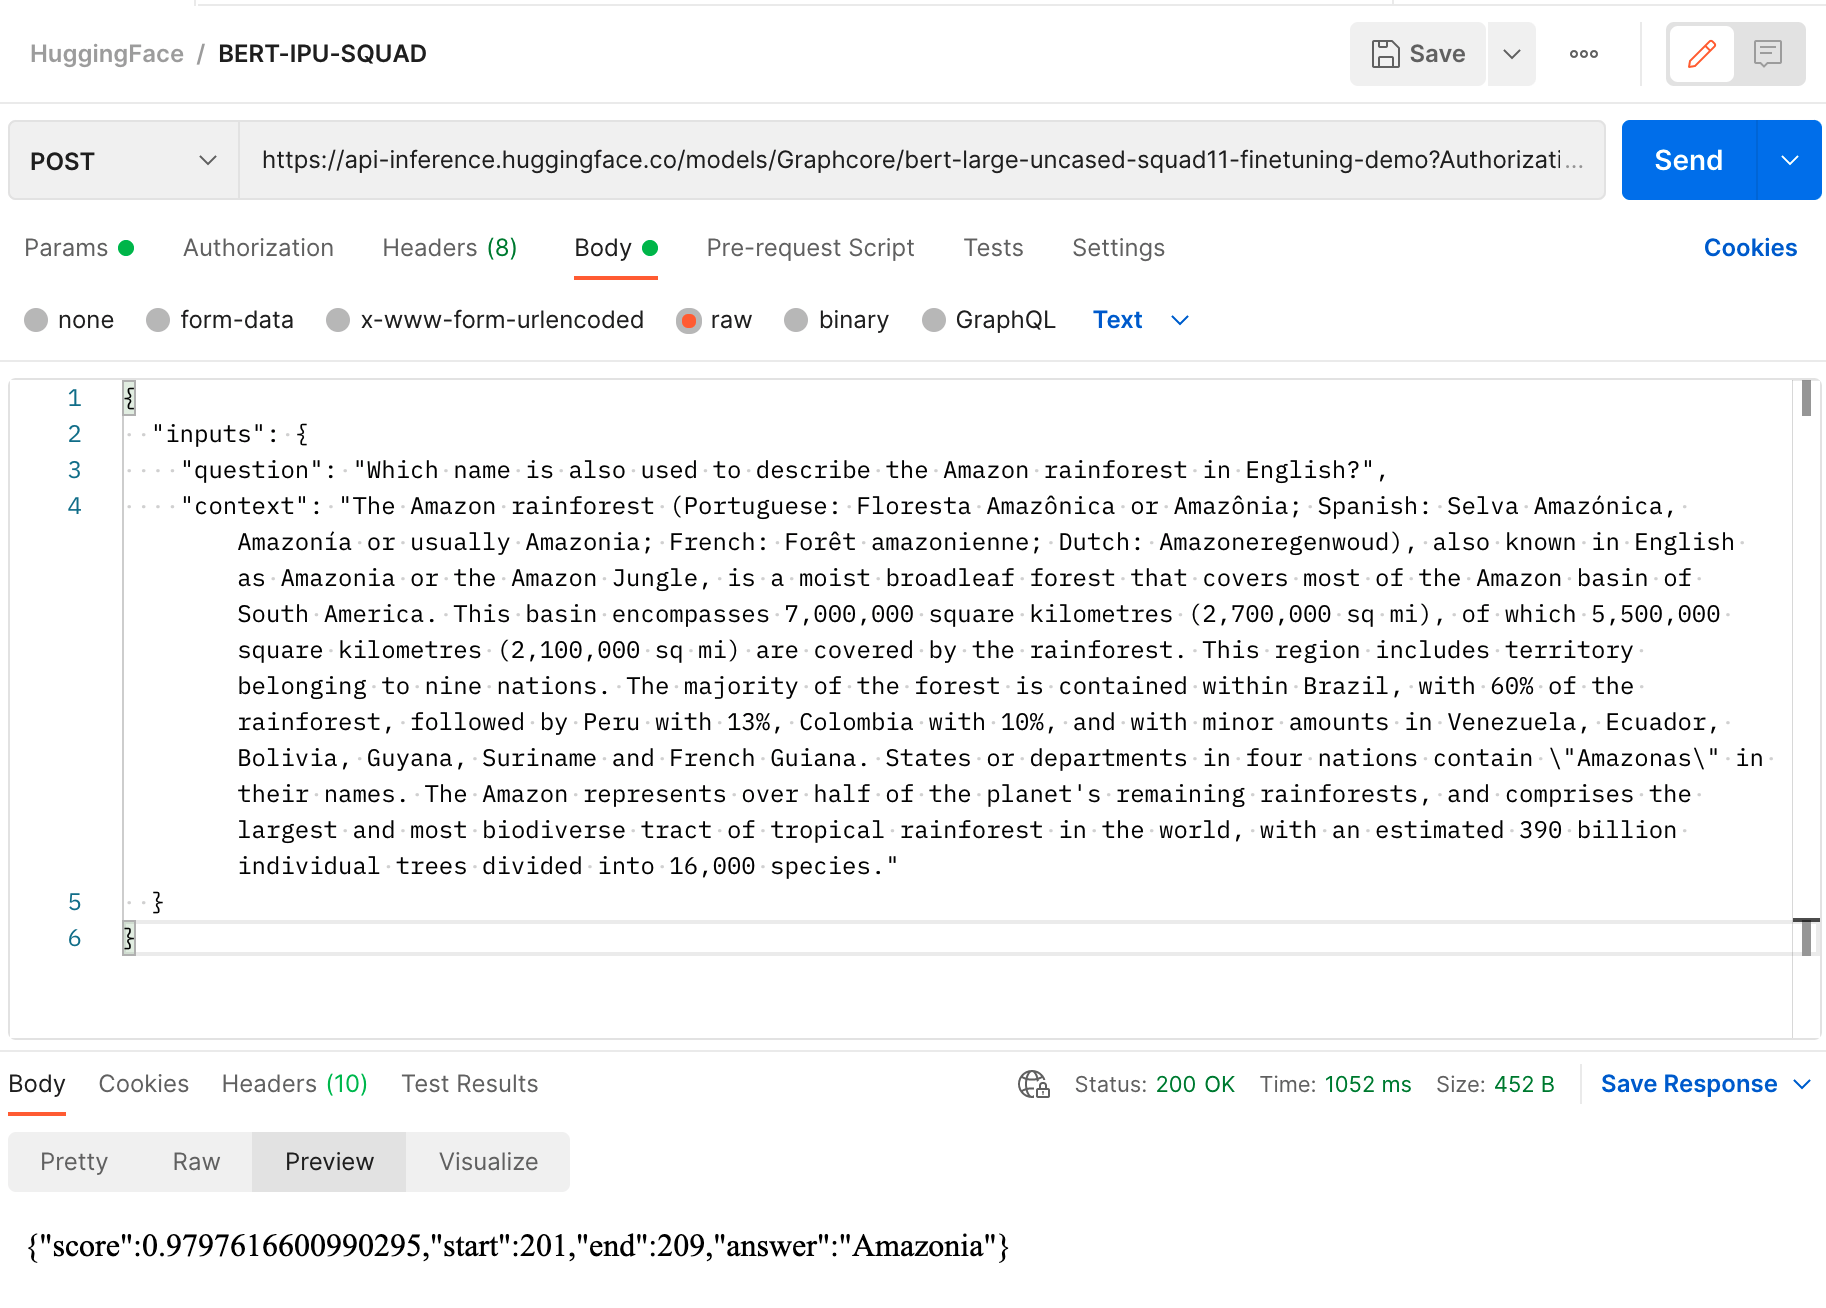


**That's it for today folks. We learned how to fine-tune a BERT-Large model using Hugging Face Optimum the SQuADv1.1 dataset to get SOTA performance and serve models through Hugging Face Hub. Our model can now answer questions.**